# Querying human lung cell atlas to classify query cells

In this tutorial we will show how to map and classify data using the [Human Lung Cell Atlas](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1) as a reference. We use the scANVI model and KNN classifier from scArches to perform batch correction, query cell classification and label transfer.

In our mappings we will also display five different levels of cell annotation and their uncertainties.

Initial version of this notebook was compiled by Lisa Sikemma.

## Setup

### Import libraries and set figure parameters

In [1]:
import os

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import scarches as sca
import gdown
import gzip
import shutil

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

### Set relevant anndata.obs labels, training/surgery length and kwargs

Here we use an example [dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171668) from the [Delorey et al. publication](  https://www.nature.com/articles/s41586-021-03570-8.). We only use the fresh, single-cell sample from this dataset.

In [4]:
batch_key = 'dataset'
query_batch = ['test_dataset_delorey_regev']

In [5]:
surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

### Download reference model and atlas

If you haven't done so already, download the HLCA core reference model and embedding that are available on zenodo (doi: 10.5281/zenodo.6337966, see https://zenodo.org/record/6337966#.Yid5Vi9Q28U).

In [6]:
url = 'https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad'
output = 'HLCA_emb_and_metadata.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad
To: /home/icb/aleksandra.topalova/scarches/notebooks/HLCA_emb_and_metadata.h5ad
100%|██████████| 218M/218M [00:40<00:00, 5.33MB/s] 


'HLCA_emb_and_metadata.h5ad'

In [7]:
url = 'https://zenodo.org/record/6337966/files/HLCA_reference_model.zip'
output = 'HLCA_reference_model.zip'
gdown.download(url, output, quiet=False)
shutil.unpack_archive('HLCA_reference_model.zip')
os.remove(output)

Downloading...
From: https://zenodo.org/record/6337966/files/HLCA_reference_model.zip
To: /home/icb/aleksandra.topalova/scarches/notebooks/HLCA_reference_model.zip
100%|██████████| 5.32M/5.32M [00:00<00:00, 5.48MB/s]


## Preprocessing

As our query data is already cleaned, subset to 2000 genes and downloaded, we simply load it and the reference data.

In [8]:
adata_ref = sc.read_h5ad('HLCA_emb_and_metadata.h5ad')
adata_query_unprep = sc.read_h5ad('HLCA_query.h5ad')

Model conversion is needed to switch from the old to the new save format.

In [9]:
sca.models.SCANVI.convert_legacy_save("HLCA_reference_model", "HLCA_reference_model", overwrite=True)

We pad missing query genes with zeros and reorder the available ones to ensure data corectness and smooth running of the scArches reference mapping.

In [10]:
ref_model_path = 'HLCA_reference_model'
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata = adata_query_unprep,
    reference_model = ref_model_path,
    inplace=False)

INFO     File HLCA_reference_model/model.pt already downloaded                                                     
INFO     Found 99.65% reference vars in query data.                                                                


This line should be kept unchanged due to the structure of the pre-trained reference model.

In [11]:
adata_query.obs['scanvi_label'] = 'unlabeled'

## Perform surgery on reference model and train on query dataset without cell type labels

### Surgery

Now we perform scArches "surgery".

Note: if you use gene names rather than ensembl IDs in your query_data.var.index, you will get a warning that your genes (var_names) do not match the training genes. You can ignore this warning, as long as you have done the gene check in the beginning of the notebook.

In [12]:
surgery_model = sca.models.SCANVI.load_query_data(
        adata_query,
        ref_model_path,
        freeze_dropout = True,
    )

INFO     File HLCA_reference_model/model.pt already downloaded                                                     


### Training

In [13]:
surgery_model.train(
     max_epochs=surgery_epochs,
    **early_stopping_kwargs_surgery
)

INFO     Training for 500 epochs.                                                                                  


INFO:pytorch_lightning.utilities.rank_zero:Multiprocessing is handled by SLURM.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO:pytorch_lightning.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 500/500: 100%|██████████| 500/500 [01:30<00:00,  6.25it/s, loss=510, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:30<00:00,  5.52it/s, loss=510, v_num=1]


### Save trained surgery model (Optional)

In [14]:
surgery_path = 'surgery_model'
surgery_model.save(surgery_path, overwrite=True)

### Get latent representation

Here we will calculate the "latent representation", or "low-dimensional embedding" of your dataset. This embedding is in the same space as the HLCA core/reference embedding that you loaded in the beginning of the script. Hence, we can combine the two embeddings afterwards (HLCA + your new data), and do joint clustering, UMAP embedding, label transfer etc.!

In [15]:
adata_query_latent = sc.AnnData(surgery_model.get_latent_representation(adata_query))
adata_query_latent.obs = adata_query.obs.loc[adata_query.obs.index,:]

## Combine embeddings

We add "reference or query" metadata to acquire more information and better analyse the integration level.

In [16]:
adata_query_latent.obs['ref_or_query'] = "query"
adata_ref.obs['ref_or_query'] = "ref"

We will now combine the two embeddings to enable joing clustering etc. If you expect non-unique barcodes (.obs index), set index_unique to e.g. "_" and batch_key to the obs column that you want to use as barcode suffix (e.g. "dataset").

In [17]:
combined_emb = adata_ref.concatenate(adata_query_latent, index_unique=None) # index_unique="_", batch_key="dataset") # alternative

We save the combined embeddings (optional).

In [18]:
combined_emb.write_h5ad('combined_embedding.h5ad')

Note that if wanted, this embedding can be added to the full, joint HLCA + query data object (including gene counts). The full HLCA, including normalized counts is publicly available. For now, we will just work with the embedding, since that is all we need to perform joint plotting and label transfer.

## Label transfer

Next, we use a knn classifier to transfer the lables from the reference to the query. We do this for every level of the annotation (i.e. level 1-5).
Note that some cell types don't have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. For those cell types, we "propagate" to the higher levels, i.e. you will see "3_Mast cells" in level 4 and 5 annotations. (Most cell types don't have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5.

In [19]:
url = 'https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv'
celltypes = 'HLCA_celltypes_ordered.csv'
gdown.download(url, celltypes, quiet=False)


Downloading...
From: https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv
To: /home/icb/aleksandra.topalova/scarches/notebooks/HLCA_celltypes_ordered.csv
5.81kB [00:00, 8.01MB/s]                   


'HLCA_celltypes_ordered.csv'

Import the set of finest cell type labels, and their matching lower-level annotations (cell types are also ordered in a biologically sensible order in this table, you can use this order for downstream plotting etc. if wanted):

In [20]:
cts_ordered = pd.read_csv(celltypes,index_col=0)    

Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

In [21]:
knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=adata_ref,
    train_adata_emb="X",
    n_neighbors=50,
)

Weighted KNN with n_neighbors = 50 ... 

In [22]:
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_query_latent,
    query_adata_emb="X", # location of our joint embedding
    label_keys="Level",
    knn_model=knn_transformer,
    ref_adata_obs = adata_ref.obs.join(cts_ordered, on='ann_finest_level')
    )

finished!


With the commands above, we labeled every cell from the query. However, some cells might have high label transfer uncertainty. It is useful to set those to "unknown" instead of giving them a cell type label. This will help highlight cell types/states that are new (i.e. not present in the reference) and possible interesting, they're worth taking a careful look at!

This uncertainty threshold limits the false positive rate to <0.5 (as per [Sikkema et al., bioRxiv 2022](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1))

In [23]:
uncertainty_threshold = 0.2

We will now copy the unfiltered cell type labels ("Level_[level]transfered_label_unfiltered"), the uncertainty scores ("Level[level]transfer_uncert") and the filtered cell type labels (i.e. including "unknown", "Level[level]_transfered_label") to our combined_emb object.

In [24]:
labels.rename(columns={f'Level_{lev}':f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)},inplace=True)
uncert.rename(columns={f'Level_{lev}':f'Level_{lev}_transfer_uncert' for lev in range(1,6)},inplace=True)

In [25]:
combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

In [26]:
t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]

Convert uncertainties to arrays

In [27]:
combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

Convert cell type labels to categoricals, and set "nan" to NaN 

In [28]:
for col, uncert in zip(t_labels,t_uncert):
    filtered_colname = col.replace('_unfiltered','')
    # too high uncertainty levels => set to "Unknown"
    combined_emb.obs[filtered_colname] = combined_emb.obs[col]
    combined_emb.obs[filtered_colname].mask(
        combined_emb.obs[uncert] > uncertainty_threshold,
        'Unknown',
        inplace = True)
    
    # convert to categorical:
    combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
    combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
    # then replace "nan" with NaN (that makes colors better in umap)
    combined_emb.obs[col].replace('nan',np.nan,inplace=True)
    combined_emb.obs[filtered_colname].replace('nan',np.nan,inplace=True)

Let's take a look at the percentage of cells set to "unknown" after our filtering:

In [29]:
print(f'Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:')
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] =='Unknown')/adata_query.n_obs*100,2)}%")

Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 0.5%
Level 2: 1.12%
Level 3: 10.64%
Level 4: 51.4%
Level 5: 51.51%


## UMAP

The UMAP plots help us perform downstream analysis, like clustering, label transfer, integration and more.

### UMAP Query vs. Reference

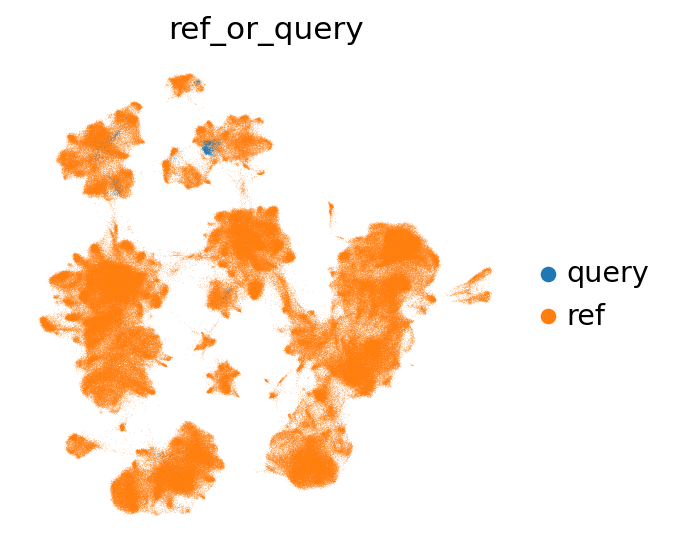

In [30]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)
sc.pl.umap(
        combined_emb,
        color='ref_or_query',
        frameon=False,
        wspace=0.6
        )

### UMAP Uncertainties 

Here we show label transfer uncertainties per level. Regions with high uncertainty can highlight interesting cell types/states, not present in the reference. Note that uncertainties will get higher, the more detailed we go:

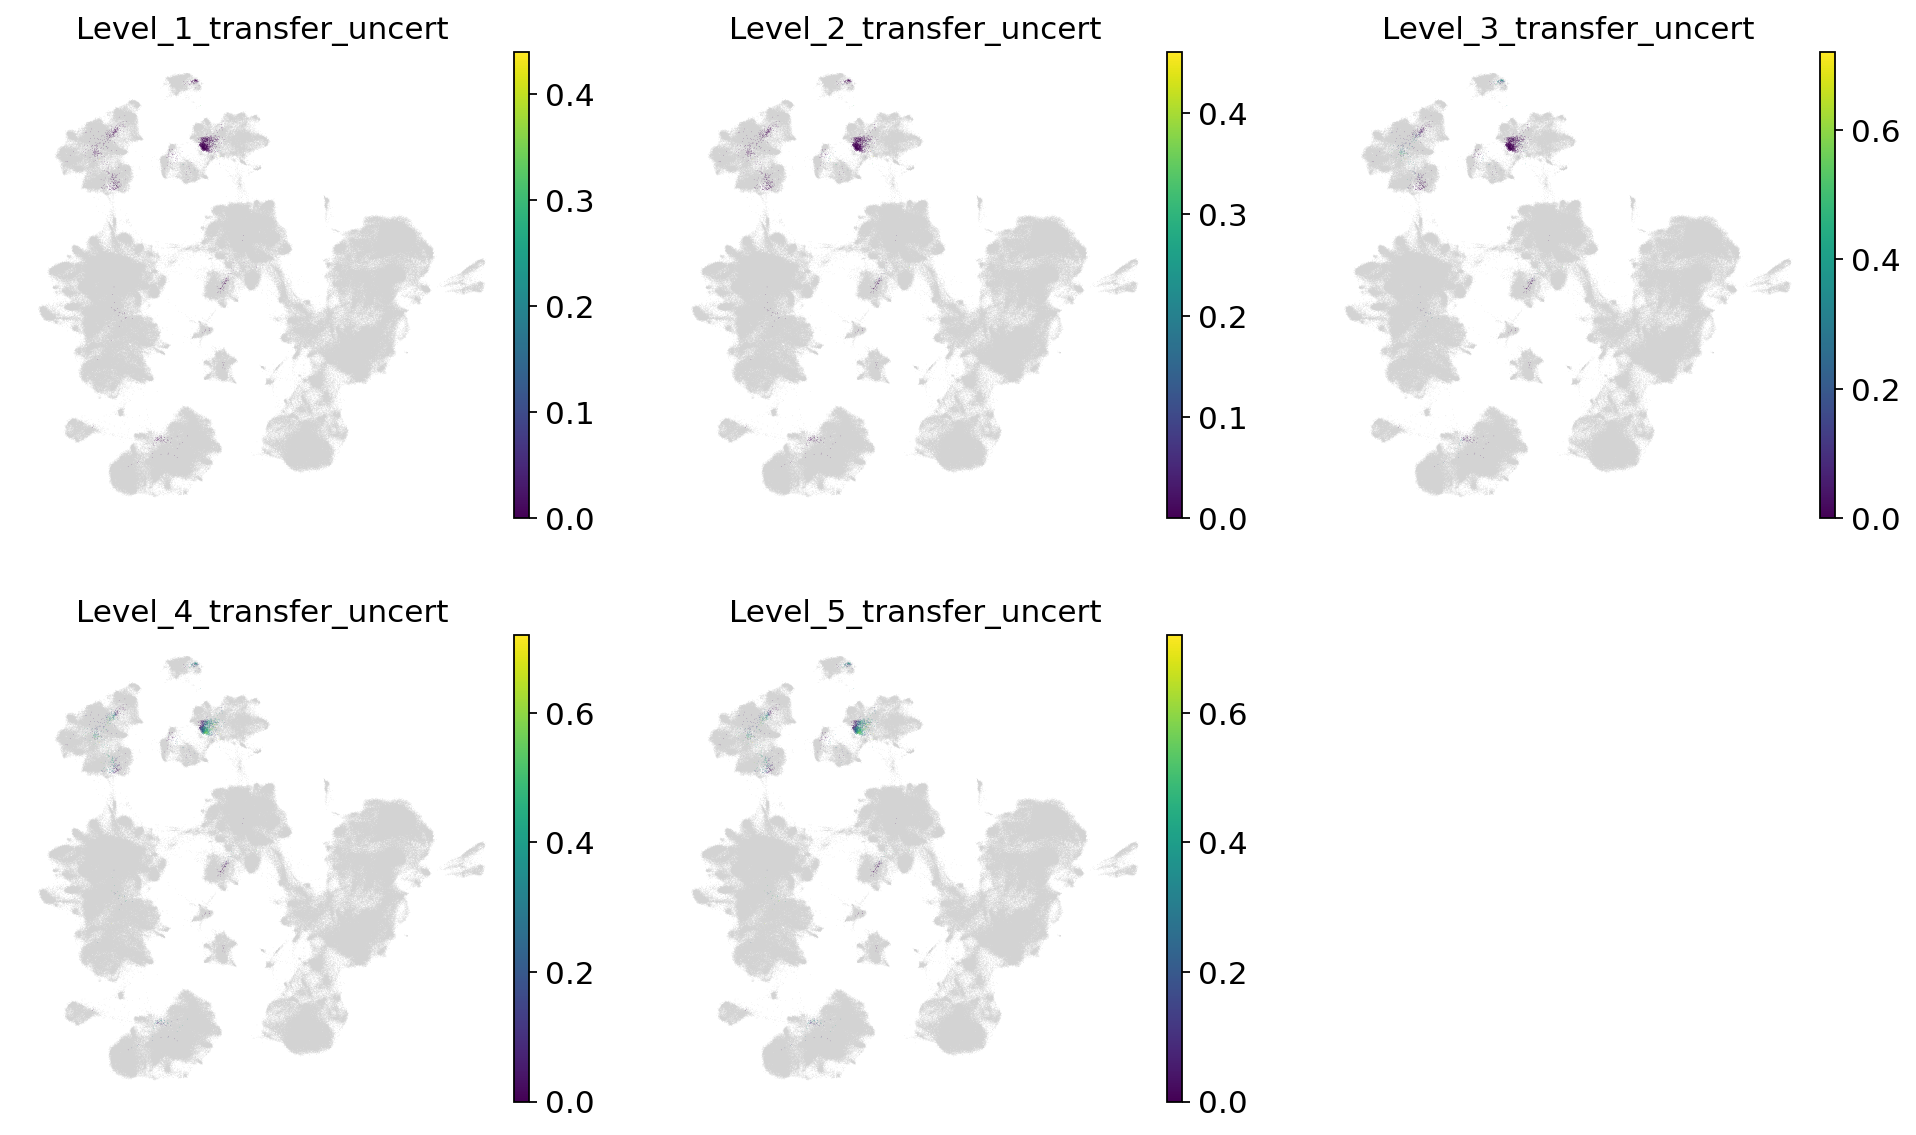

In [31]:
sc.pl.umap(
    combined_emb,
    color=[f'Level_{lev}_transfer_uncert' for lev in range(1,6)],
    ncols=3,
    frameon=False,
    )

### UMAP Label Transfer Levels

Now let's take a look at the transfered labels, at every level. Note that the color for "Unknown" switches per plot.

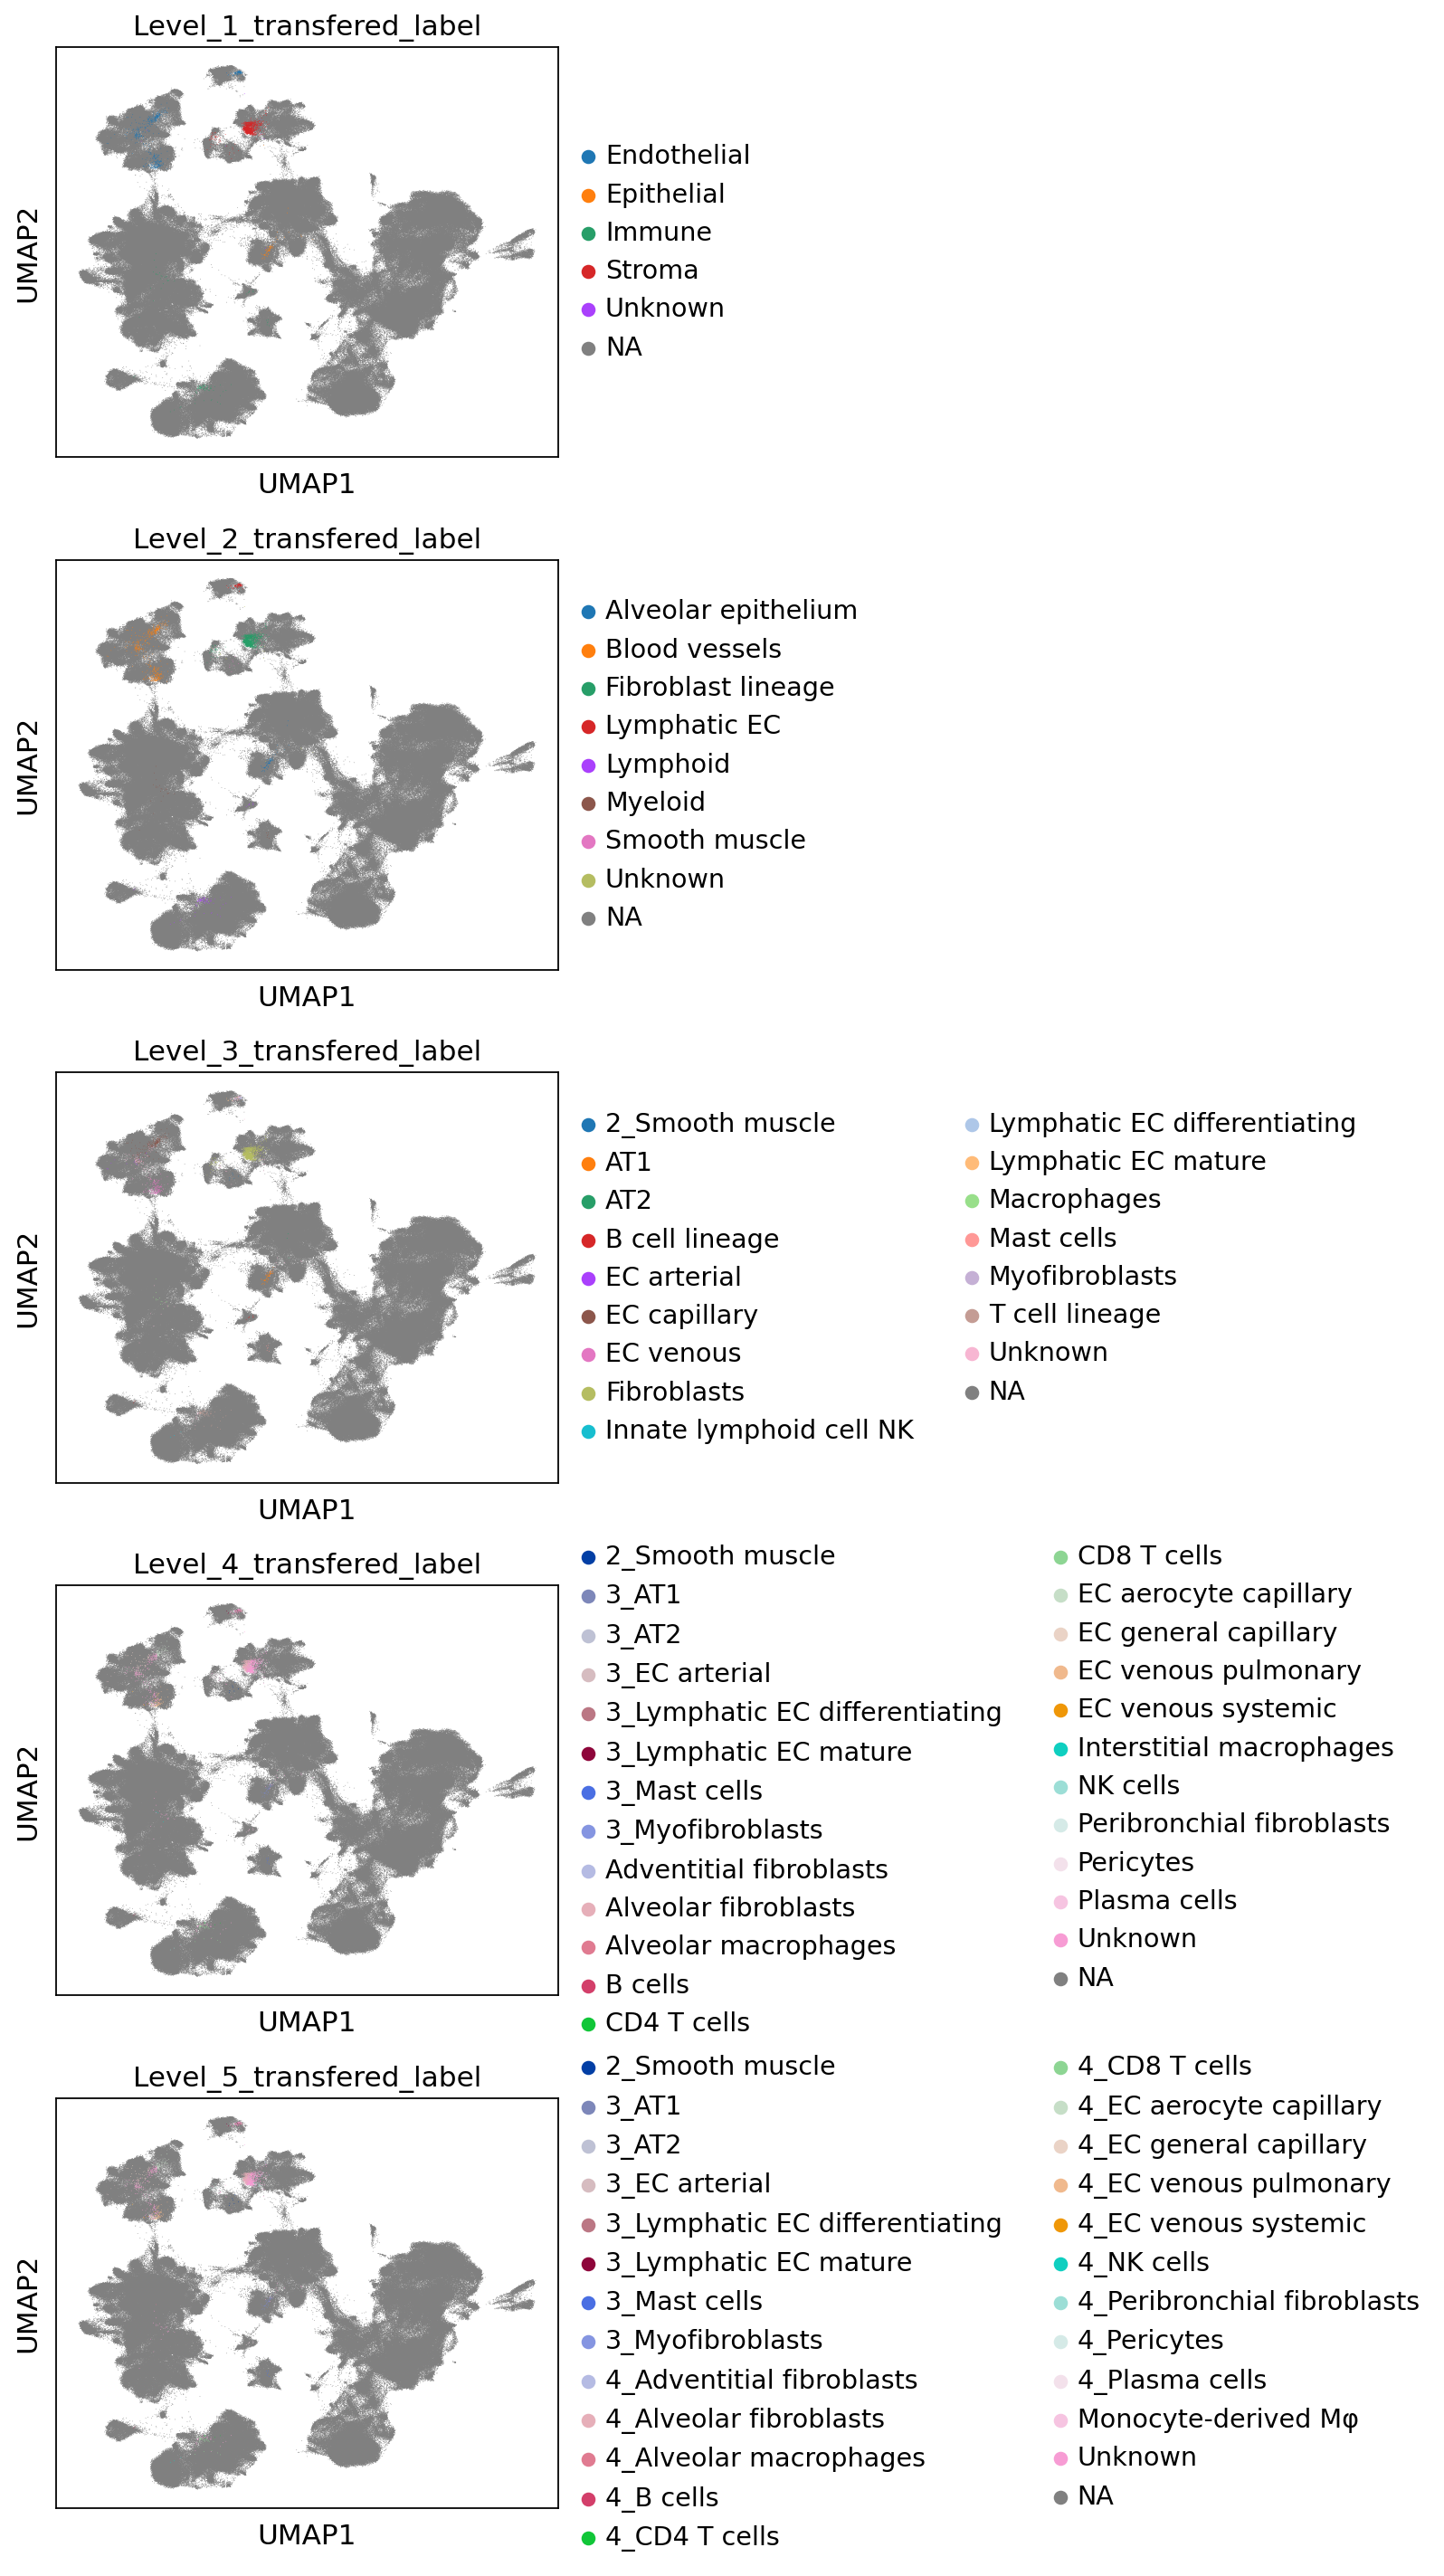

In [32]:
sc.pl.umap(
        combined_emb,
        color=[f"Level_{lev}_transfered_label" for lev in range(1,6)],
        na_color="grey",
        ncols=1,
        size=0.5
)

### UMAP Combined highest level annotation

For your reference, these are the annotations of the reference atlas:

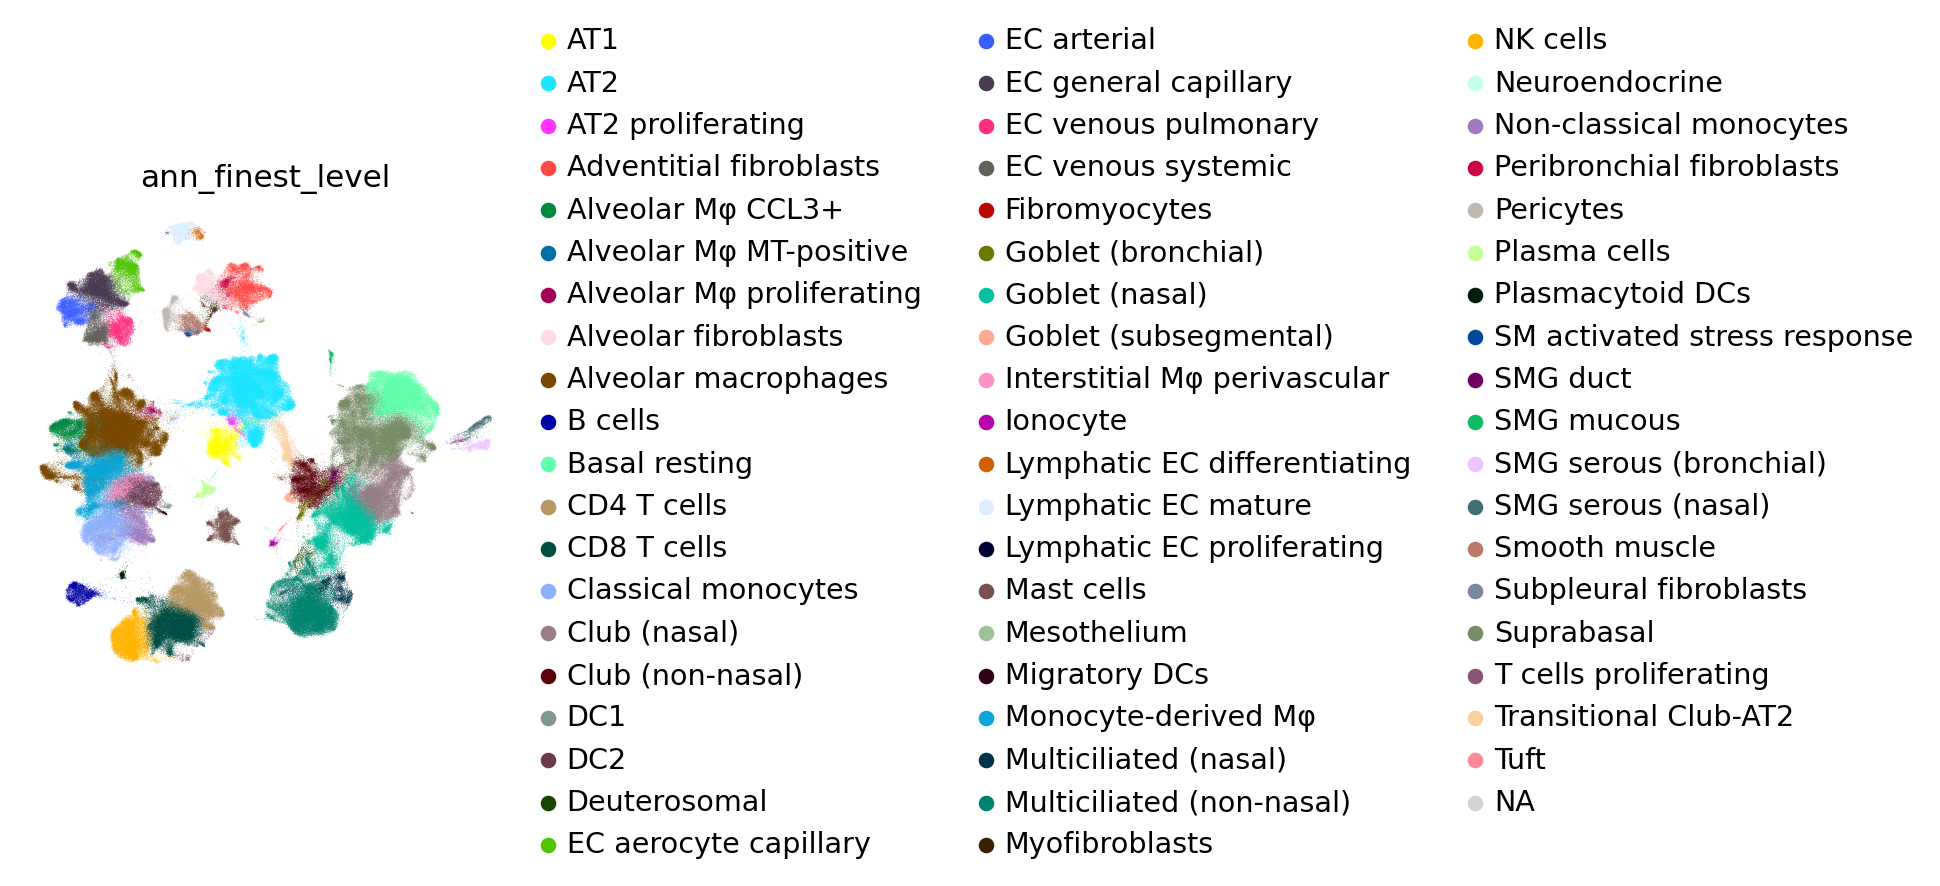

In [33]:
sc.pl.umap(
    combined_emb,
    color='ann_finest_level',
    frameon=False,
    wspace=0.6
)